# Total RMSE for performance assessment of ARPEGE-Climat PPE

<a id="top">This code</a> is combining the metric of four different variables (tas, pr, SW, LW) to create an aggretated metric $E_{tot}$ used for performance assessment and seleciton of an optimal sub-set of parametrizations. 

### [Step 1 - Emulator skill evaluation](#skill)
### [Step 2 - Initial guess for optimization 1 ](#init1)
### [Step 3 - Optimisation 1 ](#optim1)
### [Step 4 - Initial guess for Optimization 2 (param. smoothing)](#init2)
### [Step 5 - Optimisation 2](#optim2)
### [Step 6 - Optimal subset of parameters](#selection)
### [Step 7 - Simulation of optimal subset of parameters with ARPEGE-Climat 6.3](#validation)

## Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

## Functions

In [2]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    if variable == 'tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

# FONCTION MOYENNE NORMALISEE DES VARIABLES

def Norm_Average_df(Fdbck, variables, E_p1_df, name) :

    E_df = pd.DataFrame()
    E_df['Fdbck'] = Fdbck

    tmp = [0]*len(E_df) 

    for i in variables :
        E = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/'+name+'_'+i+'.npy')
        E_df['RMSE_'+i] = E

        E_df['RMSE_'+i+'_norm'] = E_df['RMSE_'+i]/E_p1_df['E_p1_'+i]

        tmp = tmp + E_df['RMSE_'+i+'_norm']
    
    E_df['RMSE_total'] = tmp/len(variables)
    return E_df

In [3]:
def MultiLinReg_RMSE_skill_eval(limit_train, x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X[0:limit_train], y[0:limit_train])
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'_'+variable+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'_'+variable+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def function_RMSE_emulator_std_skill_eval(limit_train, x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_RMSE_skill_eval(limit_train,x, 1, variable)
    pc2 = MultiLinReg_RMSE_skill_eval(limit_train,x, 2, variable)
    pc3 = MultiLinReg_RMSE_skill_eval(limit_train,x, 3, variable)
    pc4 = MultiLinReg_RMSE_skill_eval(limit_train,x, 4, variable)
    pc5 = MultiLinReg_RMSE_skill_eval(limit_train,x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_total_skill_eval(limit_train, x, variables, E_p1_df):
    
    tmp_list = []
    for i in variables : 
            tmp = function_RMSE_emulator_std_skill_eval(limit_train, x,i)
            tmp_2 = tmp/E_p1_df['E_p1_'+i]
            tmp_list.append(tmp_2)
    
    E = sum(tmp_list)*1/len(variables)
    
    return E

In [4]:
# FONCTIONS FEEDBACKS

def em_fdb_std_skill_eval(limit_train, x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X[0:limit_train], y[0:limit_train])
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [5]:
# FUNCTIONS EMULATORS

def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'_'+variable+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'_'+variable+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred


def Lasso_pred(x, EOF_nb, variable, alpha) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = Lasso(alpha=alpha)
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'_'+variable+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'_'+variable+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [6]:
# FONCTIONS ERROR

def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    if variable =='tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E


# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable, alpha): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = Lasso_pred(x, 1, variable, alpha)
    pc2 = Lasso_pred(x, 2, variable, alpha)
    pc3 = Lasso_pred(x, 3, variable, alpha)
    pc4 = Lasso_pred(x, 4, variable, alpha)
    pc5 = Lasso_pred(x, 5, variable, alpha)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x, variable, alpha): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable, alpha)
    return E

def function_RMSE_total(x, variables, E_p1_df, alpha):
    
    tmp_list = []
    for i in variables : 
            tmp = function_RMSE_emulator(x,i, alpha)
            tmp_2 = tmp/E_p1_df['E_p1_'+i]
            tmp_list.append(tmp_2)
    
    E = sum(tmp_list)*1/len(variables)
    
    return E
    

In [7]:
# FONCTION JACOBIAN

def jacobian(x, variable, alpha) :
    
    if variable == 'tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    Beta1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta1_'+variable+'.npy')
    Beta2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta2_'+variable+'.npy')
    Beta3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta3_'+variable+'.npy')
    Beta4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta4_'+variable+'.npy')
    Beta5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta5_'+variable+'.npy')
    
    R1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R1_'+variable+'.npy')
    R2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R2_'+variable+'.npy')
    R3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R3_'+variable+'.npy')
    R4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R4_'+variable+'.npy')
    R5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R5_'+variable+'.npy')
    
    C1 = R1 - U_obs[0]
    C2 = R2 - U_obs[1]
    C3 = R3 - U_obs[2]
    C4 = R4 - U_obs[3]
    C5 = R5 - U_obs[4]
    
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    A = x_std*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + (Beta1*C1 + Beta2*C2 + Beta3*C3 + 
                                                                    Beta4*C4 + Beta5*C5)
    
    tmp = x_std**2*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + 2*x_std*(Beta1*C1 + Beta2*C2 + Beta3*C3 + Beta4*C4 + Beta5*C5) +(C1**2+C2**2+C3**2+C4**2+C5**2)
    B = sqrt(tmp)
    
    D = 1/sqrt(5)
    
    jac = (A/B)*D
    
    return jac

# FONCTION JACOBIAN OF TOTAL ERROR

def jacobian_total(x, variables, E_p1_df, alpha) :
    
    tmp = 0
    for i in variables : 
        tmp0 = jacobian(x, i, alpha)/E_p1_df['E_p1_'+i]
        tmp = tmp + tmp0
    
    jac = tmp/len(variables)
    
    return jac

In [8]:
# FONCTIONS FEEDBACKS

def em_fdb_std(x, alpha) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = Lasso(alpha=alpha)
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_fdb(x, alpha) :
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std, alpha)
    return y_pred

In [9]:

# FONCTIONS CONTRAINTES

def constraint1(x, fdb_low, fdb_hi, alpha):
    tmp = (em_fdb(x, alpha))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (tmp-fdb_low)
    return test

def constraint2(x, fdb_low, fdb_hi, alpha):
    tmp = (em_fdb(x, alpha))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (fdb_hi-tmp)
    return test


# FONCTIONS OPTIMISATION

def Optimization(x_best, ind, xlim, variables, E_p1_df, alpha_E, alpha_F) :
    
    sol_list=[]
    sol_fdbck=[]
    sol_x=[]
    n = len(x_best)
    cpt=0
    
    for i in range(0, n, 1) :
        x0 = x_best[i]
        #if em_fdb(x0)<-1.8 : 
        #    ind = 0.0001
        #elif em_fdb(x0)>-1.0:
        #    ind = 0.0001
        #else:
        #    ind = 0.0001
   
        fdb_low = em_fdb(x0, alpha_F)-ind
        #print('low = '+str(fdb_low))
        fdb_hi = em_fdb(x0, alpha_F)+ind
        #print('hi = '+str(fdb_hi))

        fdb_x0 = em_fdb(x0, alpha_F)
        #print('fdb_x0 = '+str(fdb_x0))
        fun_x0 = function_RMSE_total(x0, variables, E_p1_df, alpha_E)
        #print('fun_x0 = '+str(fun_x0))

        cons1 = {'type': 'ineq', 'fun' : constraint1, 'args' : [fdb_low, fdb_hi, alpha_F]}
        cons2 = {'type': 'ineq', 'fun' : constraint2, 'args' : [fdb_low, fdb_hi, alpha_F]}
    
        sol = minimize(function_RMSE_total,  x0, args=(variables, E_p1_df, alpha_E), method='SLSQP', bounds=xlim, constraints=(cons1, cons2), 
                   jac = jacobian_total, options={'disp': True}, tol = 0.001)    
                        # , 'maxiter' : 250   jac = jacobian,
    

        tmp_fun = function_RMSE_total(sol.x, variables, E_p1_df, alpha_E)
        tmp_fdbck = em_fdb(sol.x, alpha_F)
        #print('fdb_x = '+str(tmp_fdbck))
    
        sol_list.append(tmp_fun)
        sol_fdbck.append(tmp_fdbck)
        sol_x.append(sol.x)
    
        #if tmp_fun<=fun_x0 and fdb_low<=tmp_fdbck<=fdb_hi:  
        #    sol_list.append(tmp_fun)
        #    sol_fdbck.append(tmp_fdbck)
        #else :
        #    print('\n ERROR \n')
    
    sol_df = pd.DataFrame()
    sol_df['sol_fun'] = sol_list[:]
    sol_df['Fdbck'] = sol_fdbck[:]
    j=1
    for i in range(0, 30, 1) :
        #print(j)
        sol_df['x'+str(j)+'_smth_0'] = (transpose(sol_x)[i])
        j+=1
    
    return sol_df

In [10]:
def smooth(n, df1, df2):

    for i in range(1,31,1) :
        tmp_x =[df1['x'+str(i)+'_smth_'+str(n-1)][0]]

        for j in range(1,len(df1)-1, 1) : 
            tmp = 0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j-1]+0.5* \
            df1['x'+str(i)+'_smth_'+str(n-1)][j]+0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j+1]
            
            tmp_x.append(tmp)
    
        tmp_x.append(df1['x'+str(i)+'_smth_'+str(n-1)][(len(df1)-1)])
        
        df2['x'+str(i)+'_smth_'+str(n)] = tmp_x

    return df2

## Settings

In [11]:
variables = ['tas', 'pr', 'SW', 'LW']

variable_plot = 'total'
TITLE = 'Total'
ylabel = '$E_{tot}$ (no units)'

product = 'BEST'
alpha_E = 0.05
alpha_F = 0.01

## Get the data

### p1 default

In [12]:
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
E_p1_df = {}

for i in variables :
    E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+i+'.npy')
    E_p1_df['E_p1_'+i] = E_p1

E_p1_df

{'E_p1_tas': array(2.08017959),
 'E_p1_pr': array(1.99925075),
 'E_p1_SW': array(1.664249),
 'E_p1_LW': array(1.00782632)}

In [13]:
E_p1_tmp = E_p1_df['E_p1_tas']/E_p1_df['E_p1_tas'] + E_p1_df['E_p1_pr']/E_p1_df['E_p1_pr'] + E_p1_df['E_p1_SW']/E_p1_df['E_p1_SW']+E_p1_df['E_p1_LW']/E_p1_df['E_p1_LW']
E_p1 = E_p1_tmp/4
E_p1

1.0

### CFMIP

In [14]:
def Error(path, filename, U_obs):
    
    U = np.load(path+filename)

    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]

    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [15]:
path = '/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/'

MRI = {}
CAN = {}
MIROC = {}
HadGEM3 = {}
IPSL = {}
BCC = {}

for i in variables :
    
    if i == 'tas' :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+i+'_'+product+'.npy')
    else :
        U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+i+'.npy')
    
    filename = 'U_MRI_'+i+'.npy'
    MRI[i] = Error(path, filename, U_obs)

    filename = 'U_CAN_'+i+'.npy'
    CAN[i] = Error(path, filename, U_obs)

    filename = 'U_MIROC_'+i+'.npy'
    MIROC[i] = Error(path, filename, U_obs)

    filename = 'U_HadGEM3_'+i+'.npy'
    HadGEM3[i] = Error(path, filename, U_obs)

    filename = 'U_IPSL_'+i+'.npy'
    IPSL[i] = Error(path, filename, U_obs)

    filename = 'U_BCC_'+i+'.npy'
    BCC[i] = Error(path, filename, U_obs)
    

E_MRI_tmp = MRI['tas']/E_p1_df['E_p1_tas'] + MRI['pr']/E_p1_df['E_p1_pr'] + MRI['SW']/E_p1_df['E_p1_SW']+MRI['LW']/E_p1_df['E_p1_LW']
E_MRI = E_MRI_tmp/4

E_CAN_tmp = CAN['tas']/E_p1_df['E_p1_tas'] + CAN['pr']/E_p1_df['E_p1_pr'] + CAN['SW']/E_p1_df['E_p1_SW']+CAN['LW']/E_p1_df['E_p1_LW']
E_CAN = E_CAN_tmp/4

E_MIROC_tmp = MIROC['tas']/E_p1_df['E_p1_tas'] + MIROC['pr']/E_p1_df['E_p1_pr'] + MIROC['SW']/E_p1_df['E_p1_SW']+MIROC['LW']/E_p1_df['E_p1_LW']
E_MIROC = E_MIROC_tmp/4

E_HadGEM3_tmp = HadGEM3['tas']/E_p1_df['E_p1_tas'] + HadGEM3['pr']/E_p1_df['E_p1_pr'] + HadGEM3['SW']/E_p1_df['E_p1_SW']+HadGEM3['LW']/E_p1_df['E_p1_LW']
E_HadGEM3 = E_HadGEM3_tmp/4

E_IPSL_tmp = IPSL['tas']/E_p1_df['E_p1_tas'] + IPSL['pr']/E_p1_df['E_p1_pr'] + IPSL['SW']/E_p1_df['E_p1_SW']+IPSL['LW']/E_p1_df['E_p1_LW']
E_IPSL = E_IPSL_tmp/4

E_BCC_tmp = BCC['tas']/E_p1_df['E_p1_tas'] + BCC['pr']/E_p1_df['E_p1_pr'] + BCC['SW']/E_p1_df['E_p1_SW']+BCC['LW']/E_p1_df['E_p1_LW']
E_BCC = E_BCC_tmp/4

In [16]:
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

### PPE

In [17]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")

name = 'RMSE_PPE'
E_PPE_df = Norm_Average_df(Fdbck_PPE, variables, E_p1_df, name) 
E_PPE_df

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total
0,-0.825236,1.055966,0.507632,3.017001,1.509066,1.277445,0.767581,1.877673,1.863092,1.161843
1,-1.659636,2.821711,1.356475,2.442560,1.221738,1.789840,1.075464,1.984748,1.969336,1.405753
2,-1.215000,1.710921,0.822487,3.087427,1.544292,1.302026,0.782351,1.840896,1.826601,1.243933
3,-1.321641,2.530649,1.216553,2.531341,1.266145,1.963318,1.179702,2.448370,2.429357,1.522939
4,-0.750397,1.557580,0.748772,2.996862,1.498992,0.802075,0.481944,1.488861,1.477299,1.051752
...,...,...,...,...,...,...,...,...,...,...
97,-1.516367,2.522954,1.212854,2.493090,1.247012,2.020377,1.213987,1.841523,1.827223,1.375269
98,-1.584491,2.755906,1.324840,2.493093,1.247014,1.933462,1.161763,2.008353,1.992757,1.431593
99,-1.474525,2.746495,1.320316,2.452885,1.226902,1.733249,1.041460,1.668764,1.655805,1.311121
100,-1.445422,2.584486,1.242434,2.572920,1.286942,1.691045,1.016101,1.700071,1.686869,1.308087


### Multi Lin Reg predictions

In [18]:
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")
name = 'RMSE_multilinreg_pred'

E_multilinreg_df = Norm_Average_df(Fdbck_multilinreg_pred, variables, E_p1_df, name) 
E_multilinreg_df

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total
0,-1.499698,1.969498,0.946792,2.737145,1.369086,1.452420,0.872718,1.586500,1.574180,1.190694
1,-1.339351,2.081600,1.000683,2.608792,1.304885,2.090596,1.256180,1.822507,1.808354,1.342525
2,-1.323732,2.055479,0.988126,2.371480,1.186184,1.715070,1.030537,1.608743,1.596250,1.200274
3,-1.541909,1.929926,0.927769,2.802809,1.401930,1.563995,0.939760,2.192307,2.175282,1.361185
4,-1.346961,2.403458,1.155409,2.266587,1.133718,1.646913,0.989583,1.835860,1.821604,1.275079
...,...,...,...,...,...,...,...,...,...,...
99995,-1.453679,2.522046,1.212418,2.097249,1.049017,2.578970,1.549630,1.642064,1.629313,1.360094
99996,-1.410350,2.338067,1.123973,3.071470,1.536310,2.084024,1.252231,1.194517,1.185241,1.274439
99997,-1.296397,1.954258,0.939466,2.422791,1.211849,1.277945,0.767881,1.656280,1.643418,1.140654
99998,-1.299809,2.251847,1.082525,2.590714,1.295843,1.365484,0.820480,1.283676,1.273708,1.118139


# LASSO predictions

In [19]:
Fdbck_lasso_val = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_validation_FdbckN.npy')
name = 'RMSE_lasso_val'

E_lasso_val_df = Norm_Average_df(Fdbck_lasso_val, variables, E_p1_df, name) 
E_lasso_val_df

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total
0,-1.293444,1.518014,0.729752,2.580329,1.290648,1.377178,0.827507,1.631831,1.619159,1.116766
1,-1.527259,2.440207,1.173075,2.503582,1.252260,1.824785,1.096461,1.892389,1.877693,1.349873
2,-1.214613,1.856599,0.892519,2.682224,1.341615,1.258425,0.756152,1.699910,1.686709,1.169249
3,-1.443257,2.218824,1.066650,2.514908,1.257925,1.758306,1.056516,2.139413,2.122800,1.375973
4,-1.252672,1.526953,0.734048,2.830794,1.415927,1.021881,0.614019,1.536648,1.524715,1.072177
...,...,...,...,...,...,...,...,...,...,...
97,-1.507538,2.037559,0.979511,2.441211,1.221063,1.845303,1.108790,1.696304,1.683132,1.248124
98,-1.586086,2.634870,1.266655,2.351526,1.176203,1.977422,1.188177,1.891316,1.876628,1.376916
99,-1.362889,2.319079,1.114846,2.278932,1.139893,1.875285,1.126805,1.509203,1.497483,1.219757
100,-1.509809,2.165345,1.040941,2.503695,1.252316,1.627269,0.977780,1.451236,1.439967,1.177751


In [20]:
Fdbck_lasso_pred = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_prediction_FdbckN.npy')
name = 'RMSE_lasso_pred'

E_lasso_df = Norm_Average_df(Fdbck_lasso_pred, variables, E_p1_df, name) 
E_lasso_df

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total
0,-1.478893,1.888555,0.907881,2.610645,1.305812,1.406773,0.845290,1.561549,1.549423,1.152101
1,-1.335622,2.010130,0.966325,2.461581,1.231252,2.037061,1.224012,1.756506,1.742865,1.291114
2,-1.302977,2.005280,0.963994,2.310652,1.155759,1.695160,1.018574,1.672195,1.659209,1.199384
3,-1.513519,1.798328,0.864506,2.895017,1.448051,1.494043,0.897728,1.853453,1.839060,1.262336
4,-1.346662,2.244948,1.079209,2.179068,1.089943,1.656535,0.995365,1.769602,1.755860,1.230094
...,...,...,...,...,...,...,...,...,...,...
99995,-1.462093,2.407571,1.157386,2.225960,1.113397,2.393123,1.437960,1.636965,1.624253,1.333249
99996,-1.406703,2.120966,1.019607,2.622744,1.311864,2.034440,1.222438,1.412502,1.401533,1.238860
99997,-1.301014,1.731411,0.832337,2.506910,1.253925,1.252482,0.752581,1.679898,1.666853,1.126424
99998,-1.356128,2.034509,0.978045,2.512926,1.256934,1.238573,0.744224,1.458064,1.446741,1.106486


### [Back to the top](#top)

# <a id="skill">Step 1 - Emulator skill evaluation</a> </li>

In [75]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")

RMSE_skill_eval = []
for i in X :
    tmp = function_RMSE_total_skill_eval(80, i, variables, E_p1_df)
    RMSE_skill_eval.append(tmp)
    
Validation_RMSE_df = pd.DataFrame()
Validation_RMSE_df['RMSE_PPE_total'] = E_PPE_df['RMSE_total']
Validation_RMSE_df['RMSE_multilinreg_val_total'] = RMSE_skill_eval
Validation_RMSE_df['RMSE_lasso_val_total'] = E_lasso_val_df['RMSE_total']
Validation_RMSE_df

,RMSE_PPE_total,RMSE_multilinreg_val_total,RMSE_lasso_val_total
0,1.161843,1.139815,1.116766
1,1.405753,1.403343,1.349873
2,1.243933,1.220692,1.169249
3,1.522939,1.486155,1.375973
4,1.051752,1.096907,1.072177
...,...,...,...
97,1.375269,1.364983,1.248124
98,1.431593,1.477164,1.376916
99,1.311121,1.262445,1.219757
100,1.308087,1.227704,1.177751


In [76]:
sum_diff=0
cpt=0
Test_set = Validation_RMSE_df[80:]
for i in Test_set['RMSE_multilinreg_val_total'] :
    j = Test_set['RMSE_PPE_total'].iloc[cpt]
    diff = (i-j)*(i-j)
    sum_diff = sum_diff+diff
    cpt+=1

n = len(Test_set)
OSE_multilinreg = sqrt(sum_diff/n)
OSE_multilinreg

0.06212808234580474

In [77]:
sum_diff=0
cpt=0
Test_set = Validation_RMSE_df[80:]
for i in Test_set['RMSE_lasso_val_total'] :
    j = Test_set['RMSE_PPE_total'].iloc[cpt]
    diff = (i-j)*(i-j)
    sum_diff = sum_diff+diff
    cpt+=1

n = len(Test_set)
OSE_lasso = sqrt(sum_diff/n)
OSE_lasso

0.08854677832489977

In [78]:
r_multilinreg = np.corrcoef(Validation_RMSE_df['RMSE_multilinreg_val_total'], Validation_RMSE_df['RMSE_PPE_total'])
r_multilinreg

array([[1.        , 0.85930528],
       [0.85930528, 1.        ]])

In [79]:
r_lasso = np.corrcoef(Validation_RMSE_df['RMSE_lasso_val_total'], Validation_RMSE_df['RMSE_PPE_total'])
r_lasso

array([[1.        , 0.83939889],
       [0.83939889, 1.        ]])

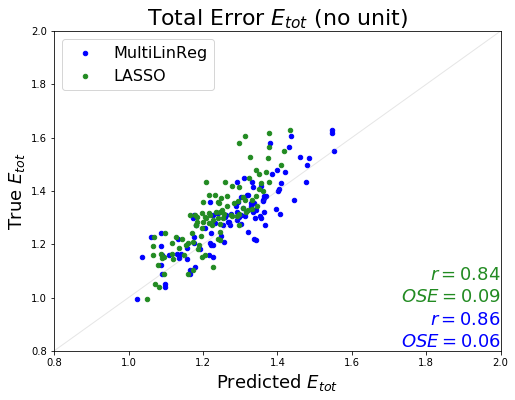

In [80]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Total Error $E_{tot}$ (no unit)"
Validation_RMSE_df[:].plot(kind='scatter', x='RMSE_multilinreg_val_total', y='RMSE_PPE_total', color='blue',  
                     marker="o", ax = ax)
#Validation_RMSE_df[80:].plot(kind='scatter', x='RMSE_multilinreg_val_total', y='RMSE_PPE_total', color='red',  
#                     marker="o", ax = ax)

Validation_RMSE_df[:].plot(kind='scatter', x='RMSE_lasso_val_total', y='RMSE_PPE_total', color='forestgreen',  
                     marker="o", ax = ax)
#Validation_RMSE_df[80:].plot(kind='scatter', x='RMSE_lasso_val_total', y='RMSE_PPE_total', color='orange',  
#                     marker="o", ax = ax)

plt.text(1,0,r'$OSE = 0.06$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, color='blue', fontsize=18)
plt.text(1,0.07,r'$r = 0.86$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, color='blue', fontsize=18)

plt.text(1,0.14,r'$OSE = 0.09$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, color='forestgreen', fontsize=18)
plt.text(1,0.21,r'$r = 0.84$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, color='forestgreen', fontsize=18)

plt.ylabel('True $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.xlabel('Predicted $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.legend(['MultiLinReg', 'LASSO'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0.8,2)
plt.xlim(0.8,2)
ax.plot((0, 4), (0, 4), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/total_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [41]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")

Fdbck_skill_eval = []
for i in X :
    tmp = em_fdb_std_skill_eval(80, i)
    Fdbck_skill_eval.append(tmp)

Fdbck_lasso_val = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_validation_FdbckN.npy')

Validation_fdbck_df = pd.DataFrame()
Validation_fdbck_df['Fdbck_PPE'] = E_PPE_df['Fdbck']
Validation_fdbck_df['Fdbck_multilinreg_val'] = Fdbck_skill_eval
Validation_fdbck_df['Fdbck_lasso_val'] = Fdbck_lasso_val
Validation_fdbck_df

,Fdbck_PPE,Fdbck_multilinreg_val,Fdbck_lasso_val
0,-0.825236,-1.180536,-1.293444
1,-1.659636,-1.594507,-1.527259
2,-1.215000,-1.068508,-1.214613
3,-1.321641,-1.363567,-1.443257
4,-0.750397,-1.140111,-1.252672
...,...,...,...
97,-1.516367,-1.550227,-1.507538
98,-1.584491,-1.635200,-1.586086
99,-1.474525,-1.418686,-1.362889
100,-1.445422,-1.621942,-1.509809


In [45]:
sum_diff=0
cpt=0
Test_set_fdbck = Validation_fdbck_df[80:]
for i in Test_set_fdbck['Fdbck_multilinreg_val'] :
    j = Test_set_fdbck['Fdbck_PPE'].iloc[cpt]
    diff = (i-j)*(i-j)
    sum_diff = sum_diff+diff
    cpt+=1

n = len(Test_set_fdbck)
OSE_multilinreg = sqrt(sum_diff/n)
OSE_multilinreg

0.18506045695913942

In [46]:
sum_diff=0
cpt=0
Test_set_fdbck = Validation_fdbck_df[80:]
for i in Test_set_fdbck['Fdbck_lasso_val'] :
    j = Test_set_fdbck['Fdbck_PPE'].iloc[cpt]
    diff = (i-j)*(i-j)
    sum_diff = sum_diff+diff
    cpt+=1

n = len(Test_set_fdbck)
OSE_lasso = sqrt(sum_diff/n)
OSE_lasso

0.0981304936644729

In [47]:
r_multilinreg = np.corrcoef(Validation_fdbck_df['Fdbck_multilinreg_val'], Validation_fdbck_df['Fdbck_PPE'])
r_multilinreg

array([[1.       , 0.7259311],
       [0.7259311, 1.       ]])

In [48]:
r_lasso = np.corrcoef(Validation_fdbck_df['Fdbck_lasso_val'], Validation_fdbck_df['Fdbck_PPE'])
r_lasso

array([[1.        , 0.73663402],
       [0.73663402, 1.        ]])

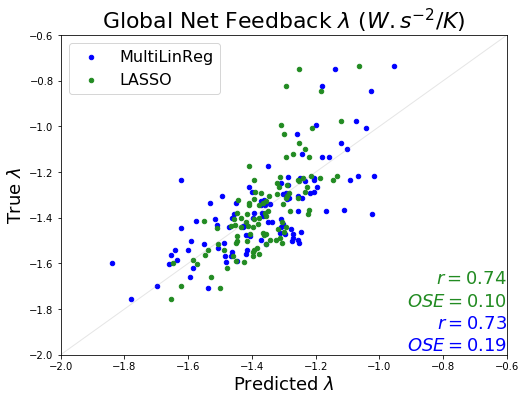

In [52]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Global Net Feedback $\lambda$ ($W.s^{-2}/K$)"
Validation_fdbck_df[:].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
#Validation_fdbck_df[80:].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_multilinreg_val', color='red',  
#                     marker="o", ax = ax)

Validation_fdbck_df[:].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_lasso_val', color='forestgreen',  
                     marker="o", ax = ax)
#Validation_fdbck_df[80:].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_lasso_val', color='orange',  
#                     marker="o", ax = ax)

plt.text(1,0,r'$OSE = 0.19$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, color='blue', fontsize=18)
plt.text(1,0.07,r'$r = 0.73$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, color='blue', fontsize=18)

plt.text(1,0.14,r'$OSE = 0.10$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, color='forestgreen', fontsize=18)
plt.text(1,0.21,r'$r = 0.74$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, color='forestgreen', fontsize=18)

plt.ylabel('True $\lambda$', fontsize = 18)#, fontsize=18)
plt.xlabel('Predicted $\lambda$', fontsize = 18)#, fontsize=18)
plt.legend(['MultiLinReg', 'LASSO'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(-2.0,-0.6)
plt.xlim(-2.0,-0.6)
ax.plot((-2.0,-0.6), (-2.0,-0.6), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/Fdbck_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

## Neural Network

In [96]:
# Set the X and Y : Y = f(X)
#X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/param_reduce.npy")
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
#y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/files/npy/PPE2_EOF3pc_N.npy")
y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [97]:
# split the dataset
X_train = X[0:80,:]
X_test = X[80:,:]
#X_val = X[40:,:]

y_train = y[0:80]
y_test = y[80:]
#y_val = y[40:]

In [136]:
from sklearn.model_selection import GridSearchCV

grid_param = {
    'max_iter' : [300,400,500,600,700,800,900,1000],
    'hidden_layer_sizes': [(5,5), (10,10), (10,5), (15,5), (15,15), (20,20), (20,5), (20), (15), (10), (5)]
}

NN = MLPRegressor()

gd_sr = GridSearchCV(estimator=NN,
                     param_grid=grid_param,
                     refit = 'cv_results_')

gd_sr.fit(X_train, y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500

{'hidden_layer_sizes': (10, 10), 'max_iter': 700}


In [152]:
NN = MLPRegressor(hidden_layer_sizes=(10,10), max_iter=900)  #
NN = NN.fit(X_train,y_train)

y_val = NN.predict(X_test)
y_pred = NN.predict(X)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_val))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_val))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_val)))

Mean Absolute Error: 0.2592369502012149
Mean Squared Error: 0.1428753878649389
Root Mean Squared Error: 0.3779886081152961


In [153]:
DFYeq_NN  = pd.DataFrame()
DFYeq_NN['y_eq'] = y_pred
DFYeq_NN['y_true'] = y
DFYeq_NN['members'] = range(0,len(y),1)
DFYeq_NN

,y_eq,y_true,members
0,-0.963394,-0.825236,0
1,-1.603138,-1.659636,1
2,-1.063793,-1.215000,2
3,-1.374766,-1.321641,3
4,-0.836995,-0.750397,4
...,...,...,...
97,-1.530357,-1.516367,97
98,-1.749361,-1.584491,98
99,-1.011748,-1.474525,99
100,-1.685203,-1.445422,100


In [154]:
sum_diff=0
cpt=0
Test_set_fdbck = DFYeq_NN[80:]
for i in Test_set_fdbck['y_eq'] :
    j = Test_set_fdbck['y_true'].iloc[cpt]
    diff = (i-j)*(i-j)
    sum_diff = sum_diff+diff
    cpt+=1

n = len(Test_set_fdbck)
OSE_NN = sqrt(sum_diff/n)
OSE_NN

0.37798860811529605

In [155]:
r_NN = np.corrcoef(DFYeq_NN['y_eq'], DFYeq_NN['y_true'])
r_NN[0,1]

0.6535836187461841

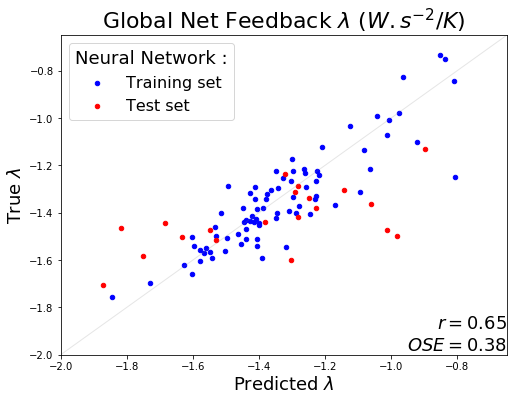

In [157]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Global Net Feedback $\lambda$ ($W.s^{-2}/K$)"
DFYeq_NN[:80].plot(kind='scatter', y='y_true', x='y_eq', color='blue',  
                     marker="o", ax = ax)
DFYeq_NN[80:].plot(kind='scatter', y='y_true', x='y_eq', color='red',  
                     marker="o", ax = ax)

#Validation_fdbck_df[80:].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_multilinreg_val', color='red',  
#                     marker="o", ax = ax)

#Validation_fdbck_df[:].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_lasso_val', color='forestgreen',  
#                     marker="o", ax = ax)
#Validation_fdbck_df[80:].plot(kind='scatter', y='Fdbck_PPE', x='Fdbck_lasso_val', color='orange',  
#                     marker="o", ax = ax)

plt.text(1,0,r'$OSE = '+str(round(OSE_NN,2))+'$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, color='black', fontsize=18)
plt.text(1,0.07,r'$r = '+str(round(r_NN[0,1],2))+'$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, color='black', fontsize=18)

#plt.text(1,0.14,r'$OSE = 0.10$',horizontalalignment='right',
#     verticalalignment='bottom', transform = ax.transAxes, color='forestgreen', fontsize=18)
#plt.text(1,0.21,r'$r = 0.74$',horizontalalignment='right',
#     verticalalignment='bottom', transform = ax.transAxes, color='forestgreen', fontsize=18)

plt.ylabel('True $\lambda$', fontsize = 18)#, fontsize=18)
plt.xlabel('Predicted $\lambda$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set', 'Test set'], title = 'Neural Network :', fontsize = 16, title_fontsize=18)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(-2.0,-0.65)
plt.xlim(-2.0,-0.65)
ax.plot((-2.0,-0.65), (-2.0,-0.65), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/NN_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="init1">Step 2 - Initial guess for optimization 1</a> </li> 

In [21]:
E_lasso_df['Fdbck_round'] = E_lasso_df['Fdbck'].round(decimals=2)
E_lasso_df = E_lasso_df.set_index('Fdbck_round')
E_lasso_df['members'] = range(0,100000,1) 
E_lasso_df        

,Fdbck,RMSE_tas,RMSE_tas_norm,RMSE_pr,RMSE_pr_norm,RMSE_SW,RMSE_SW_norm,RMSE_LW,RMSE_LW_norm,RMSE_total,members
Fdbck_round,,,,,,,,,,,
-1.48,-1.478893,1.888555,0.907881,2.610645,1.305812,1.406773,0.845290,1.561549,1.549423,1.152101,0
-1.34,-1.335622,2.010130,0.966325,2.461581,1.231252,2.037061,1.224012,1.756506,1.742865,1.291114,1
-1.30,-1.302977,2.005280,0.963994,2.310652,1.155759,1.695160,1.018574,1.672195,1.659209,1.199384,2
-1.51,-1.513519,1.798328,0.864506,2.895017,1.448051,1.494043,0.897728,1.853453,1.839060,1.262336,3
-1.35,-1.346662,2.244948,1.079209,2.179068,1.089943,1.656535,0.995365,1.769602,1.755860,1.230094,4
...,...,...,...,...,...,...,...,...,...,...,...
-1.46,-1.462093,2.407571,1.157386,2.225960,1.113397,2.393123,1.437960,1.636965,1.624253,1.333249,99995
-1.41,-1.406703,2.120966,1.019607,2.622744,1.311864,2.034440,1.222438,1.412502,1.401533,1.238860,99996
-1.30,-1.301014,1.731411,0.832337,2.506910,1.253925,1.252482,0.752581,1.679898,1.666853,1.126424,99997


In [22]:
new_df=pd.DataFrame()
new_df['RMSE_total_best'] = E_lasso_df['RMSE_total'].groupby('Fdbck_round').min()
new_df = new_df.reset_index()
new_df

,Fdbck_round,RMSE_total_best
0,-1.77,1.349948
1,-1.76,1.359488
2,-1.75,1.355553
3,-1.74,1.303852
4,-1.73,1.244341
...,...,...
76,-1.01,1.064278
77,-1.00,1.031616
78,-0.99,1.168090
79,-0.98,1.186022


In [23]:
list_RMSE = new_df['RMSE_total_best']
n = len(list_RMSE)

tmp_fdbck = []
tmp_member = []
tmp_pc1 = []
cpt=0
ind=0
cpt_other=0
for i in E_lasso_df['RMSE_total'] :
    for j in list_RMSE :
        if i==j:
            #print(cpt)
            tmp_fdbck.append(E_lasso_df['Fdbck'].iloc[cpt])
            tmp_member.append(E_lasso_df['members'].iloc[cpt])
        else :
            cpt_other+=1
    cpt+=1

fdbck = [k for k in tmp_fdbck if k != 0]
members = [l for l in tmp_member if l != 0]
pc1 = [l for l in tmp_pc1 if l != 0]

df = pd.DataFrame()
df['fdbck'] = fdbck
df['members'] = members
df_sort = df.sort_values(by=['fdbck']).reset_index().drop('index', axis=1)
df_sort

new_df['Fdbck'] = df_sort['fdbck']
new_df['members'] = df_sort['members']
new_df

,Fdbck_round,RMSE_total_best,Fdbck,members
0,-1.77,1.349948,-1.771239,78552
1,-1.76,1.359488,-1.757750,23839
2,-1.75,1.355553,-1.752328,63964
3,-1.74,1.303852,-1.744315,65073
4,-1.73,1.244341,-1.731691,33291
...,...,...,...,...
76,-1.01,1.064278,-1.012210,85801
77,-1.00,1.031616,-0.998881,54930
78,-0.99,1.168090,-0.987455,57260
79,-0.98,1.186022,-0.975995,92580


In [24]:
# CHECK OBJECTIVE FUNCTION

#x = x_best[4]
#y = function_RMSE_total(x, variables, E_p1_df, alpha_E)
#print(y)

### [Back to the top](#top)

# <a id="optim1">Step 3 - Optimization 1</a> </li> 

In [25]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")

x_best = []
for i in new_df['members']:
    #print(i)
    x_best.append(LHS[i])

x_best=np.array(x_best)
#x_best

In [26]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
#xlim

In [27]:
sol_df = Optimization(x_best, 0.0001, xlim, variables, E_p1_df, alpha_E, alpha_F)
sol_df

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.226035920763018
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.217638635665822
            Iterations: 4
            Function evaluations: 15
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2962354952630655
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2325405940121448
            Iterations: 5
            Function evaluations: 17
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2012545178271998
            Iterations: 5
            Function evaluatio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9411191007522487
            Iterations: 3
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9467412418055239
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9490591865572771
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9146296302956111
            Iterations: 3
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9332687086877465
            Iterations: 2
            Function evaluatio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0527843993239057
            Iterations: 2
            Function evaluations: 5
            Gradient evaluations: 2


,sol_fun,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.226036,-1.771139,0.174891,0.662385,0.500000,8.409195,-0.010000,6.879496e+00,1.737467,0.000500,...,-3.383007,-33.756984,0.100000,18.256161,0.000100,0.687533,0.500005,0.686873,0.500021,0.200010
1,1.217639,-1.757650,0.135128,0.660113,1.141486,3.332782,-0.010000,8.199503e+00,7.662285,0.000500,...,-1.658880,-28.408372,0.091270,16.068573,0.000100,0.907835,0.600982,0.908893,0.500000,4.193634
2,1.296235,-1.752228,0.081115,1.079328,0.647820,16.654793,-0.091106,9.876444e+00,8.960654,0.001324,...,-1.583084,-29.413090,0.069259,13.710364,0.000100,0.841715,0.905333,0.538808,0.614131,7.049796
3,1.232541,-1.744215,0.078125,0.703997,0.500000,7.745430,-0.010007,5.675240e+00,0.976222,0.000500,...,-3.969411,-27.161807,0.085198,5.939977,0.000100,0.836742,0.665749,0.815425,0.500009,4.269002
4,1.201255,-1.731602,0.115189,0.634937,0.921894,10.167671,-0.012290,6.287891e+00,5.473261,0.001014,...,-3.292059,-30.399242,0.094307,8.611397,0.000098,0.777399,0.539933,0.991577,0.515947,6.034365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1.008150,-1.012310,0.201466,2.106300,0.541612,28.854567,-0.340901,6.629622e-01,4.410282,0.002273,...,-4.975434,-40.739123,0.010000,9.822714,0.000100,0.644899,0.752727,0.977839,0.523470,1.264802
77,0.990633,-0.998981,0.220009,2.314649,0.680984,28.166349,-0.441027,2.248014e-01,8.228459,0.000500,...,-4.237146,-41.205912,0.010000,10.852296,0.000100,0.686750,0.786705,0.973989,0.903156,7.900000
78,1.038256,-0.987555,0.163994,2.330564,0.500000,17.672942,-0.328607,2.650536e-20,4.379882,0.000500,...,-1.193809,-25.721407,0.010000,1.309568,0.000100,0.662422,0.500000,1.000000,0.685880,1.460334
79,1.073973,-0.976095,0.209034,2.638829,1.445579,10.633688,-0.027751,1.209457e-01,4.465905,0.001266,...,-1.164318,-48.897747,0.010000,12.140376,0.000100,0.958949,0.983764,1.000000,0.954562,3.398581


### Plotting

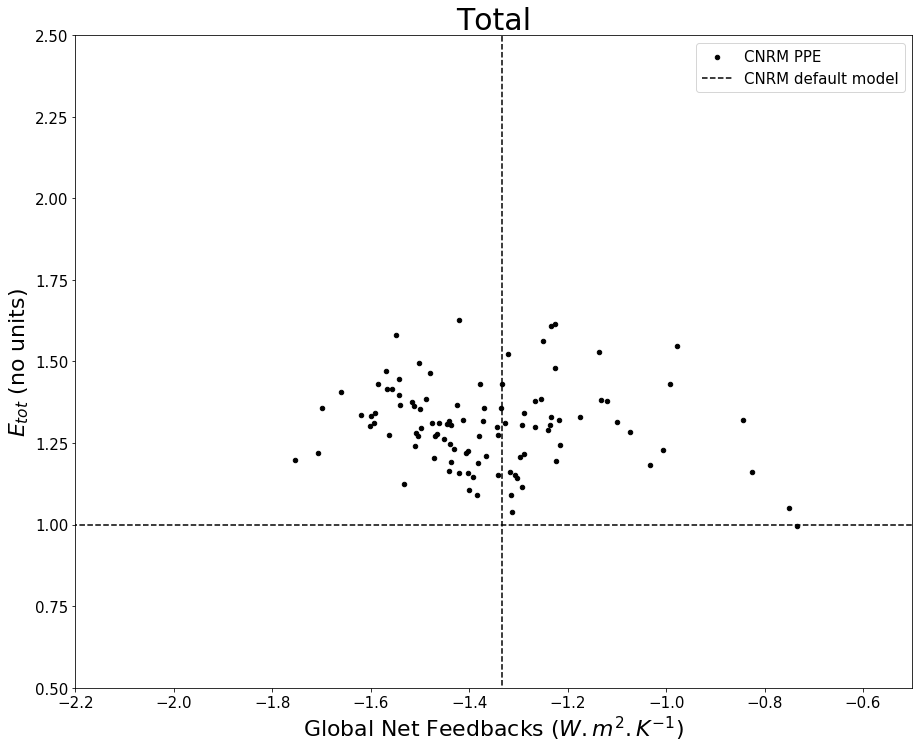

In [28]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkgreen', 
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
#         linewidth=3, ax = ax)

#E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
#                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/LASSO_RMSE_"+variable_plot+"_PPE_only.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

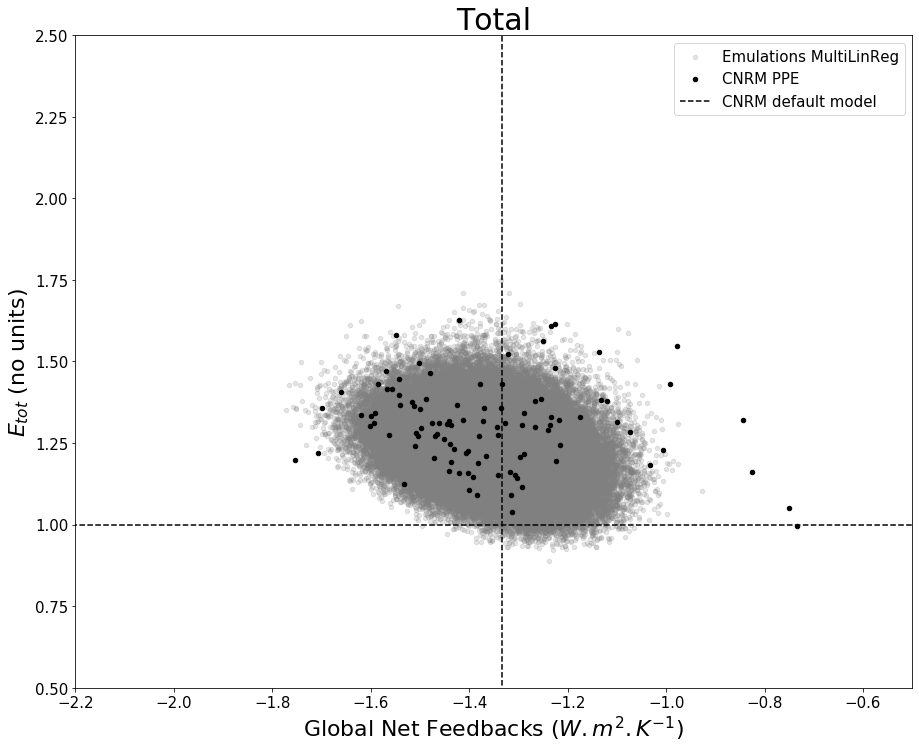

In [29]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkgreen', 
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
#         linewidth=3, ax = ax)

E_lasso_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/LASSO_RMSE_"+variable_plot+"_PPE.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

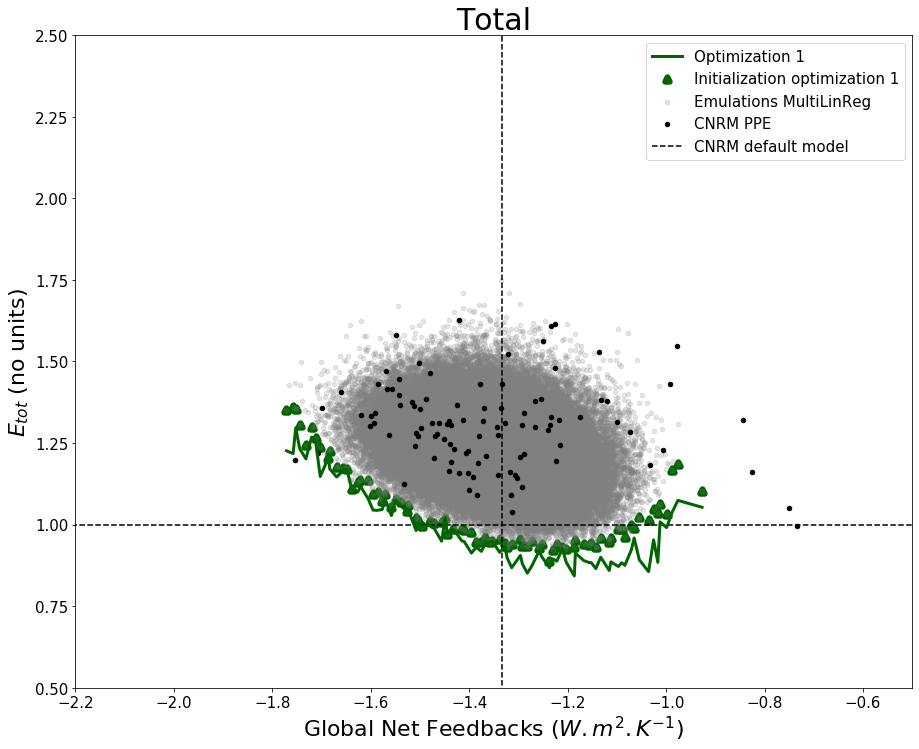

In [30]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkgreen', 
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
         linewidth=3, ax = ax)

E_lasso_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Optimization 1', 'Initialization optimization 1', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/LASSO_RMSE_"+variable_plot+"_PPE_optim1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)

#  <a id="init2">Step 4 - Initial guess for Optimization 2 (param. smoothing)</a> </li> 

In [31]:
new_sol_df = pd.DataFrame()
new_sol_df['Fdbck'] = sol_df['Fdbck']

new_sol_df = smooth(1, sol_df, new_sol_df)

n = 151
for i in range(2,n,1) :
    new_sol_df = smooth(i, new_sol_df, new_sol_df)
    
new_sol_df

,Fdbck,x1_smth_1,x2_smth_1,x3_smth_1,x4_smth_1,x5_smth_1,x6_smth_1,x7_smth_1,x8_smth_1,x9_smth_1,...,x21_smth_150,x22_smth_150,x23_smth_150,x24_smth_150,x25_smth_150,x26_smth_150,x27_smth_150,x28_smth_150,x29_smth_150,x30_smth_150
0,-1.771139,0.174891,0.662385,0.500000,8.409195,-0.010000,6.879496,1.737467,0.000500,0.000050,...,-3.383007,-33.756984,0.100000,18.256161,0.000100,0.687533,0.500005,0.686873,0.500021,0.200010
1,-1.757650,0.131566,0.765485,0.857698,7.932388,-0.030276,8.288736,6.505673,0.000706,0.000050,...,-3.345426,-33.551164,0.097291,17.538536,0.000099,0.688440,0.520453,0.696246,0.503846,0.550007
2,-1.752228,0.093871,0.880692,0.734282,11.096949,-0.050554,8.406908,6.639953,0.000912,0.000288,...,-3.307960,-33.348125,0.094603,16.828972,0.000098,0.689368,0.540585,0.705487,0.507657,0.893873
3,-1.744215,0.088139,0.780565,0.642428,10.578331,-0.030852,6.878704,4.096589,0.000835,0.000597,...,-3.270726,-33.150518,0.091959,16.135166,0.000096,0.690341,0.560098,0.714472,0.511438,1.225759
4,-1.731602,0.102788,0.673511,0.821678,9.384430,-0.012791,6.553656,3.888727,0.001135,0.000492,...,-3.233835,-32.960751,0.089377,15.464108,0.000095,0.691380,0.578721,0.723094,0.515178,1.540354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,-1.012310,0.205988,2.266282,0.670269,25.132472,-0.296148,0.730534,6.246492,0.001864,0.000120,...,-2.932739,-42.503032,0.010062,4.892134,0.000100,0.855945,0.819462,0.687600,0.838378,1.978579
77,-0.998981,0.201369,2.266540,0.600895,25.715052,-0.387891,0.278141,6.311771,0.000943,0.000072,...,-2.911079,-43.051736,0.010044,4.960521,0.000100,0.866121,0.831163,0.669920,0.855982,1.821970
78,-0.987555,0.189258,2.403651,0.781641,18.536480,-0.281498,0.086437,5.363532,0.000691,0.000050,...,-2.889630,-43.603702,0.010028,5.036823,0.000100,0.876550,0.843159,0.651377,0.874132,1.656984
79,-0.976095,0.209271,2.510884,1.270738,15.044167,-0.135635,0.113620,4.337696,0.001403,0.000068,...,-2.868329,-44.157939,0.010013,5.118557,0.000100,0.887156,0.855357,0.632233,0.892659,1.486191


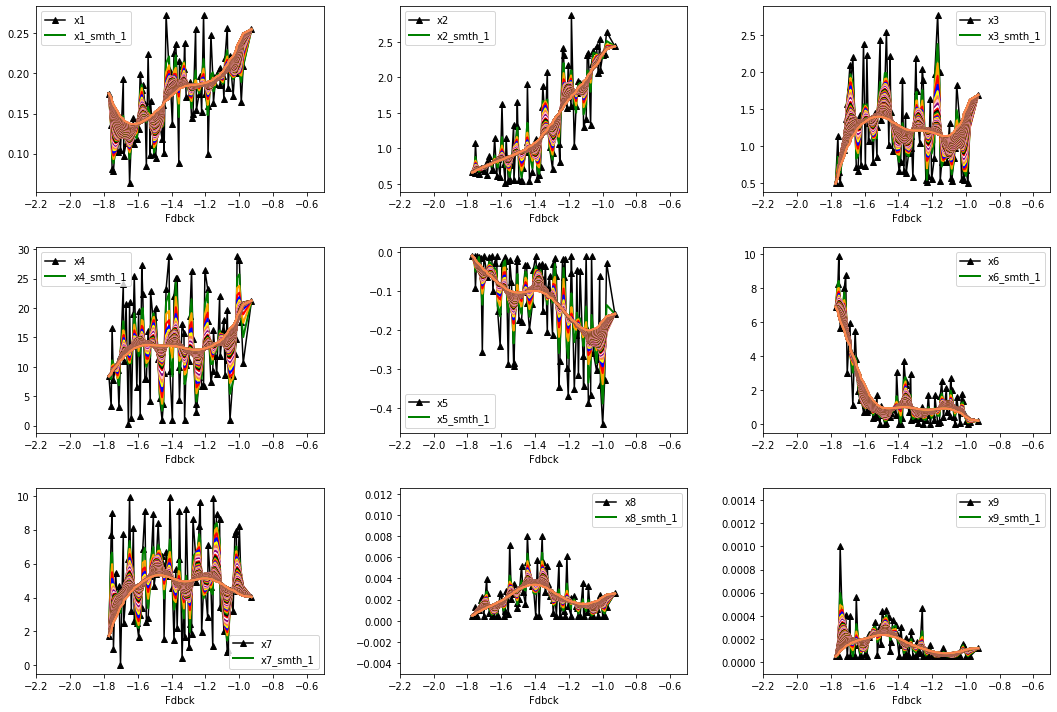

In [32]:
# SETTINGS ------------------

n = 150

colors = ['black', 'green', 'orange', 'red', 'blue', 'yellow', 'coral', 'pink', 'purple', 'white','red']*100

# Plot of lines from different dataframes
plt.subplots(figsize=(15,10)) 

plt.subplot(331)

ax1 = plt.gca()
title = 'parameter 1'

sol_df.plot(kind='line', x='Fdbck', y='x1_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax1)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x1_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax1)

plt.xlim(-2.2,-0.5)
plt.legend(['x1', 'x1_smth_1'])
plt.subplot(332)

ax2 = plt.gca()
title = 'parameter 2'

sol_df.plot(kind='line', x='Fdbck', y='x2_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax2)
for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x2_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax2)

plt.xlim(-2.2,-0.5)
plt.legend(['x2', 'x2_smth_1'])
plt.subplot(333)

ax3 = plt.gca()
title = 'parameter 3'

sol_df.plot(kind='line', x='Fdbck', y='x3_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax3)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x3_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax3)

plt.xlim(-2.2,-0.5)
plt.legend(['x3', 'x3_smth_1'])
plt.subplot(334)

ax4 = plt.gca()
title = 'parameter 4'

sol_df.plot(kind='line', x='Fdbck', y='x4_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax4)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x4_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax4)

plt.xlim(-2.2,-0.5)
plt.legend(['x4', 'x4_smth_1'])
plt.subplot(335)

ax5 = plt.gca()
title = 'parameter 5'

sol_df.plot(kind='line', x='Fdbck', y='x5_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax5)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x5_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax5)

plt.xlim(-2.2,-0.5)
plt.legend(['x5', 'x5_smth_1'])
plt.subplot(336)

ax6 = plt.gca()
title = 'parameter 6'

sol_df.plot(kind='line', x='Fdbck', y='x6_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax6)

for i in range(1,n,1) : 
    new_sol_df.plot(kind='line', x='Fdbck', y='x6_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax6)
    
plt.xlim(-2.2,-0.5)
plt.legend(['x6', 'x6_smth_1'])
plt.subplot(337)

ax7 = plt.gca()
title = 'parameter 7'

sol_df.plot(kind='line', x='Fdbck', y='x7_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax7)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x7_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax7)

plt.xlim(-2.2,-0.5)
plt.legend(['x7', 'x7_smth_1'])
plt.subplot(338)

ax8 = plt.gca()
title = 'parameter 8'

sol_df.plot(kind='line', x='Fdbck', y='x8_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax8)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x8_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax8)

plt.ylim(-0.005,0.0125)
plt.xlim(-2.2,-0.5)
plt.legend(['x8', 'x8_smth_1'])
plt.subplot(339)

ax9 = plt.gca()
title = 'parameter 9'

sol_df.plot(kind='line', x='Fdbck', y='x9_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax9)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x9_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax9)

plt.ylim(-0.0001,0.0015)
plt.xlim(-2.2,-0.5)
plt.legend(['x9', 'x9_smth_1'])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas_future4K.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)

# <a id="optim2">Step 5 - Optimisation 2</a> </li> 

In [33]:
x_best_2 = pd.DataFrame()
for k in range(1,31,1) : 
    x_best_2['x'+str(k)+'_best'] = new_sol_df['x'+str(k)+'_smth_150']

x_best_2 = x_best_2.to_numpy()
x_best_2

array([[0.17489095, 0.66238507, 0.5       , ..., 0.68687334, 0.50002135,
        0.20000955],
       [0.17015701, 0.67396228, 0.5767112 , ..., 0.69624644, 0.50384623,
        0.55000695],
       [0.16551335, 0.68551249, 0.65247953, ..., 0.70548705, 0.50765658,
        0.89387336],
       ...,
       [0.24473324, 2.35961324, 1.5620012 , ..., 0.65137681, 0.87413173,
        1.65698443],
       [0.24985048, 2.39742811, 1.62633252, ..., 0.63223263, 0.89265852,
        1.48619112],
       [0.25502138, 2.43531304, 1.69179392, ..., 0.61278008, 0.91137824,
        1.31242563]])

In [34]:
init_df = pd.DataFrame()
init_df['Fdbck'] = sol_df['Fdbck']

tmp_fun = []
for i in x_best_2 :
    tmp = function_RMSE_total(i, variables, E_p1_df, alpha_E)
    tmp_fun.append(tmp)
init_df['RMSE'] = tmp_fun
init_df

,Fdbck,RMSE
0,-1.771139,1.226036
1,-1.757650,1.214475
2,-1.752228,1.203362
3,-1.744215,1.192669
4,-1.731602,1.182349
...,...,...
76,-1.012310,0.961159
77,-0.998981,0.981376
78,-0.987555,1.003492
79,-0.976095,1.027365


In [35]:
sol_df_2 = Optimization(x_best_2, 0.0001, xlim, variables, E_p1_df, alpha_E, alpha_F)
sol_df_2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.226036160343224
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2144747802950104
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2033625442776124
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1926690601337095
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1823487562926909
            Iterations: 1
            Function evaluati

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9086892590916098
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9028222718512311
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8966123807813215
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8911717078573385
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8870398419276451
            Iterations: 2
            Function evaluati

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0399212177431252
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2


,sol_fun,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.226036,-1.771139,0.174886,0.662385,0.500000,8.409195,-0.010000,6.879458,1.737466,0.000500,...,-3.383008,-33.756981,0.099999,18.256143,0.000100,0.687533,0.500005,0.686876,0.500021,0.200010
1,1.214475,-1.760966,0.170156,0.673962,0.576709,8.811532,-0.015266,6.605546,2.004694,0.000594,...,-3.345426,-33.551164,0.097291,17.538532,0.000099,0.688440,0.520453,0.696247,0.503846,0.550005
2,1.203363,-1.750794,0.165513,0.685512,0.652479,9.211401,-0.020505,6.330610,2.268675,0.000686,...,-3.307960,-33.348125,0.094603,16.828972,0.000098,0.689368,0.540584,0.705487,0.507656,0.893873
3,1.192669,-1.740623,0.161046,0.697009,0.726398,9.606340,-0.025691,6.053782,2.526302,0.000777,...,-3.270726,-33.150518,0.091959,16.135166,0.000096,0.690341,0.560098,0.714472,0.511438,1.225759
4,1.182349,-1.730452,0.156836,0.708426,0.797632,9.993900,-0.030801,5.774415,2.774733,0.000867,...,-3.233835,-32.960751,0.089377,15.464108,0.000095,0.691380,0.578721,0.723094,0.515178,1.540354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.951717,-0.982338,0.232599,2.276345,1.433982,18.684450,-0.178441,0.493558,4.263515,0.001685,...,-2.933153,-42.500507,0.010045,4.889588,0.000100,0.855429,0.818040,0.688970,0.833519,1.973721
77,0.967428,-0.968705,0.235514,2.307601,1.487531,19.296902,-0.170493,0.415615,4.206771,0.001427,...,-2.911803,-43.047324,0.010023,4.956078,0.000100,0.865183,0.828714,0.672305,0.847375,1.813642
78,0.999543,-0.954959,0.234964,2.328040,1.534719,19.929723,-0.157611,0.321137,4.149304,0.000553,...,-2.891213,-43.594053,0.010000,5.027102,0.000100,0.874416,0.837880,0.656578,0.855043,1.639110
79,1.018840,-0.941059,0.239353,2.365160,1.598347,20.578205,-0.151501,0.247202,4.093064,0.000616,...,-2.869936,-44.148138,0.010000,5.108670,0.000100,0.884908,0.850071,0.637502,0.873009,1.468379


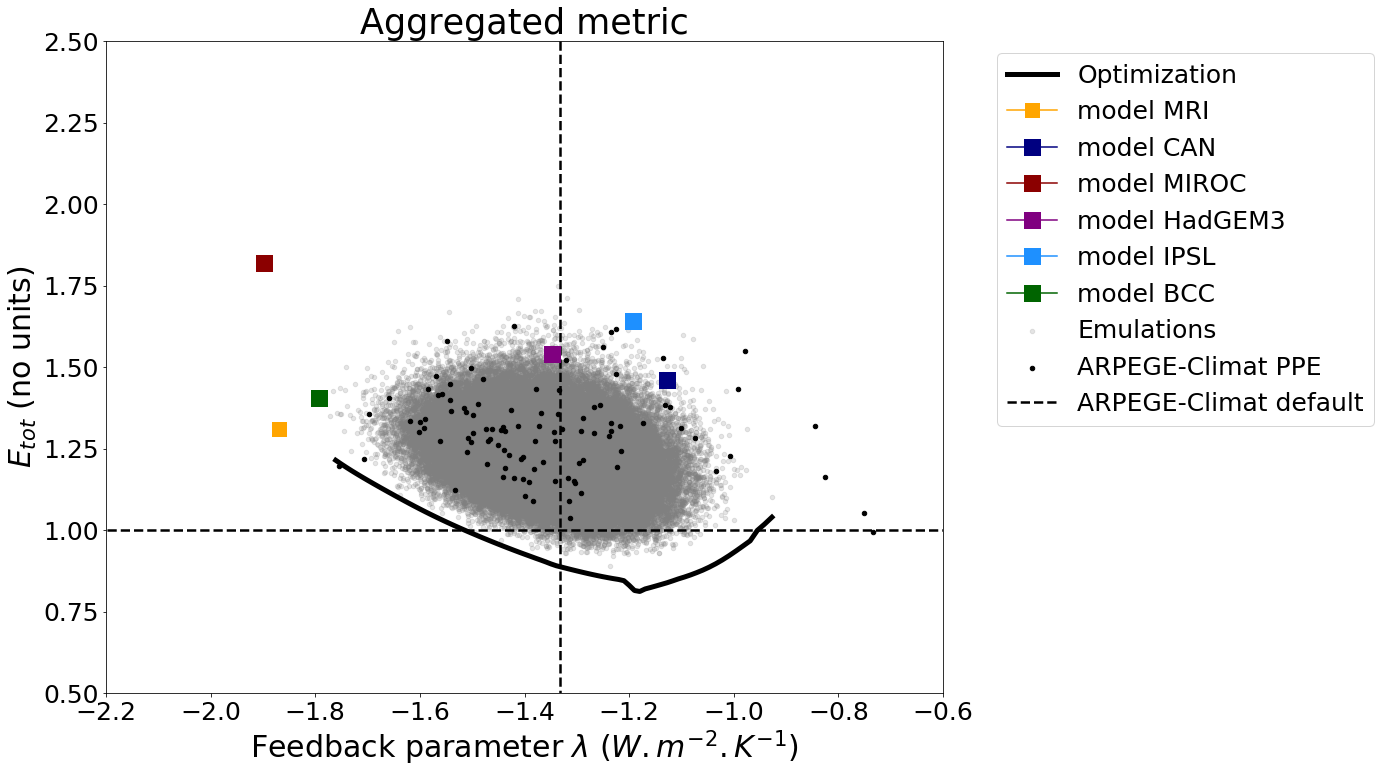

In [36]:
colors = ['coral','blue','orange','black','green','red','purple','yellow','cornflowerblue']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'black', alpha=1, linewidth=5, ax = ax)

E_lasso_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


legend = [ 'Optimization', 'model MRI','model CAN','model MIROC','model HadGEM3','model IPSL', 'model BCC', 
          'Emulations','ARPEGE-Climat PPE', 'ARPEGE-Climat default']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
plt.ylabel(ylabel, fontsize=30)
plt.legend(legend, fontsize=25, bbox_to_anchor=(1.05, 1))

plt.title('Aggregated metric', fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/LASSO_RMSE_"+variable_plot+"_PPE_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save the data

In [37]:
RMSE_optim2 = sol_df_2['sol_fun']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_RMSE_optim2_'+variable_plot+'.npy', RMSE_optim2)

Fdbck_optim2 = sol_df_2['Fdbck']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_Fdbck_optim2_'+variable_plot+'.npy', Fdbck_optim2)

### [Back to the top](#top)

# <a id="selection">Step 6 - Optimal subset of parameters</a> </li>

In [38]:
df_select = sol_df_2[sol_df_2.index % 15 == 0]
df_select = df_select.append(sol_df_2.iloc[len(sol_df_2)-1])
df_select

,sol_fun,Fdbck,x1_smth_0,x2_smth_0,x3_smth_0,x4_smth_0,x5_smth_0,x6_smth_0,x7_smth_0,x8_smth_0,...,x21_smth_0,x22_smth_0,x23_smth_0,x24_smth_0,x25_smth_0,x26_smth_0,x27_smth_0,x28_smth_0,x29_smth_0,x30_smth_0
0,1.226036,-1.771139,0.174886,0.662385,0.500000,8.409195,-0.010000,6.879458,1.737466,0.000500,...,-3.383008,-33.756981,0.099999,18.256143,0.000100,0.687533,0.500005,0.686876,0.500021,0.200010
15,1.080984,-1.619052,0.137095,0.823423,1.292924,13.147905,-0.079153,2.711544,4.563447,0.001753,...,-2.882020,-31.702973,0.067842,10.431077,0.000085,0.711386,0.697743,0.789326,0.551433,3.229577
30,0.969620,-1.469333,0.156873,0.970717,1.373673,13.608545,-0.103090,0.946985,5.312877,0.003157,...,-2.692821,-31.753235,0.044503,8.637593,0.000080,0.733812,0.746810,0.838955,0.593276,2.628781
45,0.882986,-1.319646,0.183650,1.289774,1.211392,13.151065,-0.110986,0.962407,4.950368,0.002720,...,-2.948173,-31.475884,0.019105,7.780981,0.000090,0.738154,0.729309,0.826499,0.615334,2.828094
60,0.819944,-1.169481,0.188447,1.748538,1.140905,13.454591,-0.164251,0.857026,5.085219,0.000500,...,-3.231728,-34.625330,0.010000,5.468755,0.000100,0.745026,0.703104,0.816570,0.652365,2.946997
75,0.936427,-0.995797,0.228706,2.241679,1.381310,18.098755,-0.184293,0.563207,4.320119,0.001730,...,-2.954950,-41.956657,0.010068,4.832078,0.000100,0.845736,0.807126,0.705163,0.818096,2.121138
80,1.039921,-0.927108,0.243782,2.402351,1.663093,21.234075,-0.145239,0.172370,4.036821,0.000680,...,-2.848733,-44.703390,0.010000,5.192997,0.000100,0.895489,0.862365,0.618118,0.891169,1.294676


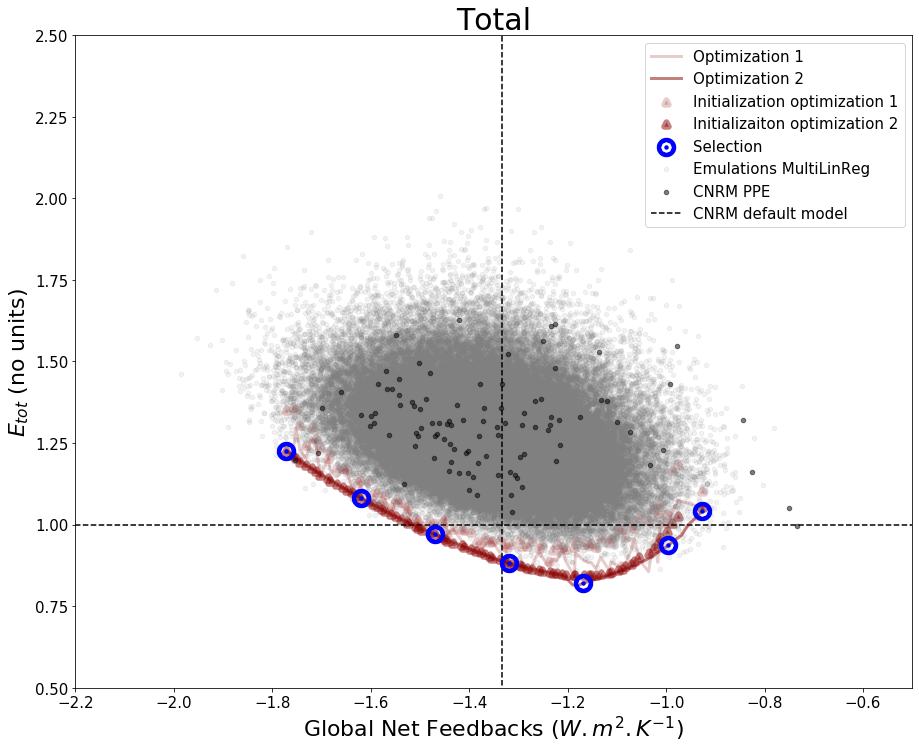

In [39]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck', y='RMSE_total_best', color = 'darkred', alpha=0.2,
         marker = '^', linewidth=6,  ax = ax)

init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkred', alpha=0.5,
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.2,
         linewidth=3, ax = ax)

sol_df_2.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkred', alpha=0.5, linewidth=3, ax = ax)

df_select.plot(kind='scatter', x='Fdbck', y='sol_fun', color='blue', marker='o', linewidth=15, 
               zorder=10, ax=ax)

E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
                           color='gray', alpha=0.1, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), alpha=0.5,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model',
legend = legend = [ 'Optimization 1', 'Optimization 2', 'Initialization optimization 1', 
                   'Initializaiton optimization 2', 'Selection', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/LASSO_RMSE_"+variable_plot+"_PPE_optim2_select.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [40]:
list_index = df_select.columns.tolist()
list_index

['sol_fun',
 'Fdbck',
 'x1_smth_0',
 'x2_smth_0',
 'x3_smth_0',
 'x4_smth_0',
 'x5_smth_0',
 'x6_smth_0',
 'x7_smth_0',
 'x8_smth_0',
 'x9_smth_0',
 'x10_smth_0',
 'x11_smth_0',
 'x12_smth_0',
 'x13_smth_0',
 'x14_smth_0',
 'x15_smth_0',
 'x16_smth_0',
 'x17_smth_0',
 'x18_smth_0',
 'x19_smth_0',
 'x20_smth_0',
 'x21_smth_0',
 'x22_smth_0',
 'x23_smth_0',
 'x24_smth_0',
 'x25_smth_0',
 'x26_smth_0',
 'x27_smth_0',
 'x28_smth_0',
 'x29_smth_0',
 'x30_smth_0']

### Save the data

In [41]:
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_RMSE_optim2_select.npy', df_select)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_RMSE_optim2_select_indexes.npy', list_index)

In [42]:
df_select_tmp = df_select.drop(['sol_fun', 'Fdbck'], axis=1)

#np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_optim2_param.txt', df_select_tmp.values)
#np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_BIS_optim2_param.txt', df_select_tmp.values)
np.savetxt('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/txt/selection_LASSO_optim2_param.txt', df_select_tmp.values)

### [Back to the top](#top)

# <a id="validation">Step 7 - Simulation of optimal subset of parameters with ARPEGE-Climat 6.3</a> </li>

### Settings

In [18]:
nb_p_list_selection = ['p821', 'p822', 'p823', 'p824','p825', 'p826']
len(nb_p_list_selection)

6

In [20]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_RMSE_optim2_select.npy')
df_select = pd.DataFrame(file).drop([0])
df_select['sol_fun'] = df_select[0]
df_select['Fdbck'] = df_select[1]
df_select = df_select
df_select

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,sol_fun,Fdbck
1,1.080984,-1.619052,0.137095,0.823423,1.292924,13.147905,-0.079153,2.711544,4.563447,0.001753,...,0.067842,10.431077,0.000085,0.711386,0.697743,0.789326,0.551433,3.229577,1.080984,-1.619052
2,0.969620,-1.469333,0.156873,0.970717,1.373673,13.608545,-0.103090,0.946985,5.312877,0.003157,...,0.044503,8.637593,0.000080,0.733812,0.746810,0.838955,0.593276,2.628781,0.969620,-1.469333
3,0.882986,-1.319646,0.183650,1.289774,1.211392,13.151065,-0.110986,0.962407,4.950368,0.002720,...,0.019105,7.780981,0.000090,0.738154,0.729309,0.826499,0.615334,2.828094,0.882986,-1.319646
4,0.819944,-1.169481,0.188447,1.748538,1.140905,13.454591,-0.164251,0.857026,5.085219,0.000500,...,0.010000,5.468755,0.000100,0.745026,0.703104,0.816570,0.652365,2.946997,0.819944,-1.169481
5,0.936427,-0.995797,0.228706,2.241679,1.381310,18.098755,-0.184293,0.563207,4.320119,0.001730,...,0.010068,4.832078,0.000100,0.845736,0.807126,0.705163,0.818096,2.121138,0.936427,-0.995797
6,1.039921,-0.927108,0.243782,2.402351,1.663093,21.234075,-0.145239,0.172370,4.036821,0.000680,...,0.010000,5.192997,0.000100,0.895489,0.862365,0.618118,0.891169,1.294676,1.039921,-0.927108


In [21]:
RMSE_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_RMSE_optim2_'+variable_plot+'.npy')
Fdbck_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LASSO_Fdbck_optim2_'+variable_plot+'.npy')
sol_df_2=pd.DataFrame(RMSE_optim_line)
sol_df_2['sol_fun'] = sol_df_2[0]
sol_df_2['Fdbck'] = Fdbck_optim_line
sol_df_2

,0,sol_fun,Fdbck
0,1.226036,1.226036,-1.771139
1,1.214475,1.214475,-1.760966
2,1.203363,1.203363,-1.750794
3,1.192669,1.192669,-1.740623
4,1.182349,1.182349,-1.730452
...,...,...,...
76,0.951717,0.951717,-0.982338
77,0.967428,0.967428,-0.968705
78,0.999543,0.999543,-0.954959
79,1.018840,1.018840,-0.941059


### Error estimate

In [22]:
PC_PPE_selection = {}

for j in variables :
    for i in nb_p_list_selection :
        PC_PPE_selection[i+'_'+j] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/U_'+i+'_'+j+'.npy')
    
PC_PPE_selection

{'p821_tas': array([ 1.363612  , -0.26870772,  1.2512805 , -0.01465998,  1.0437948 ],
       dtype=float32),
 'p822_tas': array([ 1.2911067 , -0.55892646,  0.69412214,  0.54271054,  2.7782676 ],
       dtype=float32),
 'p823_tas': array([ 0.9251286 ,  1.1146564 , -0.34388068,  1.6665676 ,  1.513044  ],
       dtype=float32),
 'p824_tas': array([ 0.3198023 , -0.77733946,  1.1938806 ,  2.5397823 ,  2.4281812 ],
       dtype=float32),
 'p825_tas': array([-0.5947073,  0.7687086, -1.7790264,  3.9360034,  1.781607 ],
       dtype=float32),
 'p826_tas': array([-0.9864388 ,  0.10705347, -1.7763354 ,  4.3401666 ,  3.0136356 ],
       dtype=float32),
 'p821_pr': array([1.55511533, 0.47426907, 0.19058501, 0.75090981, 1.67096234]),
 'p822_pr': array([ 0.80628171,  0.23636763, -0.07723478, -1.22987193,  2.78273714]),
 'p823_pr': array([-0.00311711,  1.62634041, -0.0912865 ,  0.74535651,  1.82877143]),
 'p824_pr': array([ 0.34599262,  2.54236634,  1.03727847,  3.63463227, -2.77438159]),
 'p825_pr': 

In [23]:
E_PPE_selection = {}

for j in variables :
    list_tmp = []
    for i in nb_p_list_selection :
        pc1 = PC_PPE_selection[i+'_'+j][0]
        pc2 = PC_PPE_selection[i+'_'+j][1]
        pc3 = PC_PPE_selection[i+'_'+j][2]
        pc4 = PC_PPE_selection[i+'_'+j][3]
        pc5 = PC_PPE_selection[i+'_'+j][4]
    
        list_tmp.append(Error_emulator(pc1, pc2, pc3, pc4, pc5, j))
    E_PPE_selection[j] = list_tmp

E_PPE_selection

{'tas': [1.7490700997159603,
  1.02854686378788,
  1.590341954844217,
  1.0123996976110878,
  1.8754277119832614,
  1.6919070167845816],
 'pr': [2.7303946588215977,
  3.5346102639262478,
  2.6168337113315725,
  1.2101890518903466,
  1.6694153815107604,
  2.045647467548675],
 'SW': [1.3128747501471025,
  0.882258011624449,
  0.9920607027074817,
  1.0344037639132881,
  1.219783000100522,
  1.8782268302394627],
 'LW': [1.52432583164456,
  1.2141185409059485,
  0.9334913680689064,
  0.5650473830378115,
  1.0568715549674987,
  1.5632944526292933]}

In [24]:
E_PPE_selection_total=[0]*len(E_PPE_selection['tas'])

for i in range(0,len(E_PPE_selection['tas']),1) :
    E_PPE_selection_total[i] = E_PPE_selection['tas'][i]/E_p1_df['E_p1_tas']+E_PPE_selection['pr'][i]/E_p1_df['E_p1_pr']+E_PPE_selection['SW'][i]/E_p1_df['E_p1_SW']+E_PPE_selection['LW'][i]/E_p1_df['E_p1_LW']
    E_PPE_selection_total[i] = E_PPE_selection_total[i]/4

E_PPE_selection_total

[1.1269733120652516,
 0.9993081274905062,
 0.8989430259608786,
 0.568553313019611,
 0.8795469937829397,
 1.129070373676963]

In [25]:
Fdbck_tmp = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/LASSO_Net_feedbacks.npy").tolist()
Fdbck_PPE_selection = []
for i in Fdbck_tmp :
    Fdbck_PPE_selection.append(i)
    
Fdbck_PPE_selection

[-1.6706219514211018,
 -1.5683836142222087,
 -1.0464486281077068,
 -0.7517026861508688,
 -0.6537019411722819,
 -0.7325568596522013]

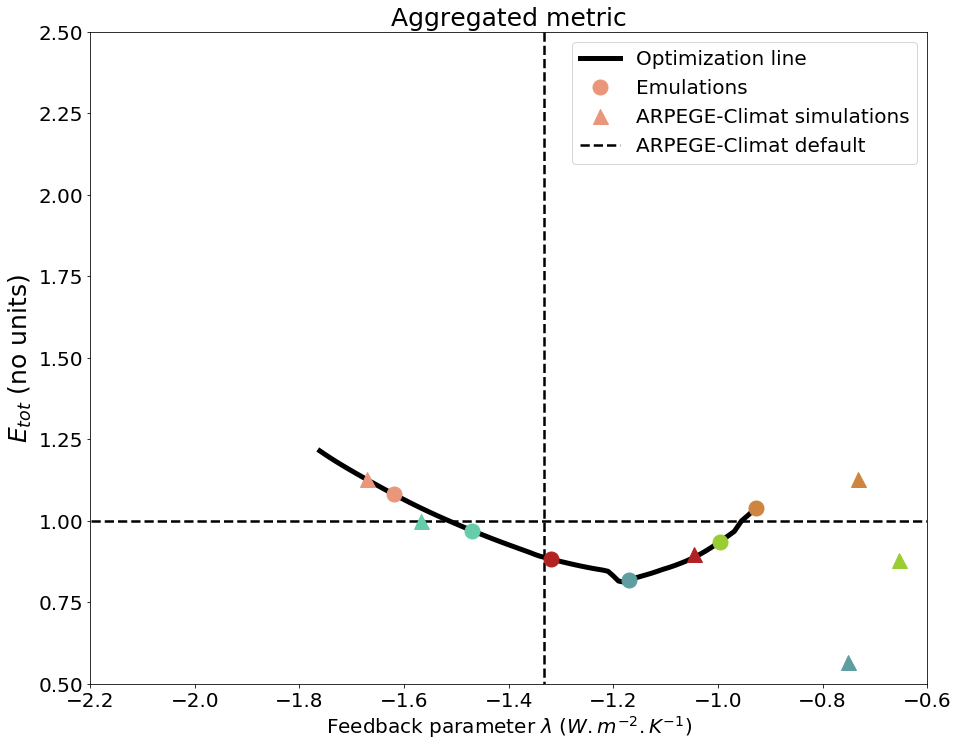

In [30]:
colors = ['darksalmon','mediumaquamarine','firebrick','cadetblue','yellowgreen','peru']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'black', alpha=1, linewidth=5, figsize=(15, 12), ax = ax)

#E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
#                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

#E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', color='black', figsize=(15, 12), 
#                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5, zorder=1)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


for i in colors :
    if cpt == 0 :
        plt.plot(df_select['Fdbck'].iloc[cpt], df_select['sol_fun'].iloc[cpt], color=i, marker='o', linewidth=0, markersize=15, zorder=8)

        plt.plot(Fdbck_PPE_selection[cpt], E_PPE_selection_total[cpt], color=i, marker='^', linewidth=0, markersize=15, zorder=9)
        cpt+=1
    else :
        plt.plot(df_select['Fdbck'].iloc[cpt], df_select['sol_fun'].iloc[cpt], color=i, marker='o', linewidth=0, markersize=15, label='_nolegend_')

        plt.plot(Fdbck_PPE_selection[cpt], E_PPE_selection_total[cpt], color=i, marker='^', linewidth=0, markersize=15, label='_nolegend_')
        cpt+=1

legend = [ 'Optimization line','Emulations','ARPEGE-Climat simulations', 'ARPEGE-Climat default']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=20)
plt.ylabel(ylabel, fontsize=25)
plt.legend(legend, fontsize=20) #bbox_to_anchor=(1.05, 1)

plt.title('Aggregated metric', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(0.5,2.5)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/LASSO_RMSE_"+variable_plot+"_PPE_optim2_select.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [68]:
df_RMSE_selection = pd.DataFrame(E_PPE_selection_total, columns=['E_arpege'])
df_RMSE_selection['E_multilinreg'] = df_select['sol_fun'].data

df_fdbck_selection = pd.DataFrame(Fdbck_PPE_selection, columns=['fdbck_arpege'])
df_fdbck_selection['fdbck_multilinreg'] = df_select['Fdbck'].data
df_fdbck_selection

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.data is deprecated and will be removed in a future version
  
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.data is deprecated and will be removed in a future version
  """


,fdbck_arpege,fdbck_multilinreg
0,-1.781610,-1.985856
1,-1.667639,-1.639310
2,-1.559913,-1.490135
3,-1.435194,-1.339147
4,-1.059083,-1.188858
5,-0.704648,-1.039423
6,-0.643735,-0.873522


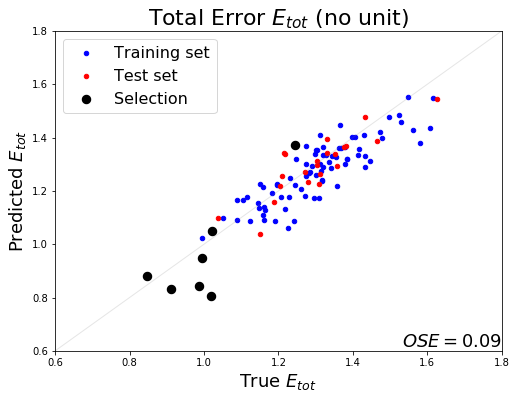

In [69]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Total Error $E_{tot}$ (no unit)"

Validation_RMSE_df[0:80].plot(kind='scatter', x='RMSE_PPE_total', y='RMSE_multilinreg_val_total', color='blue',  
                     marker="o", ax = ax)
Validation_RMSE_df[80:].plot(kind='scatter', x='RMSE_PPE_total', y='RMSE_multilinreg_val_total', color='red',  
                     marker="o", ax = ax)

df_RMSE_selection.plot(kind='scatter', x='E_arpege', y='E_multilinreg', color='black',  
                     marker="o", linewidth=5,ax = ax)

plt.text(1,0,r'$OSE = 0.09$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.xlabel('True $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted $E_{tot}$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set','Test set','Selection'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0.6,1.8)
plt.xlim(0.6,1.8)
ax.plot((0, 4), (0, 4), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/total_selection_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

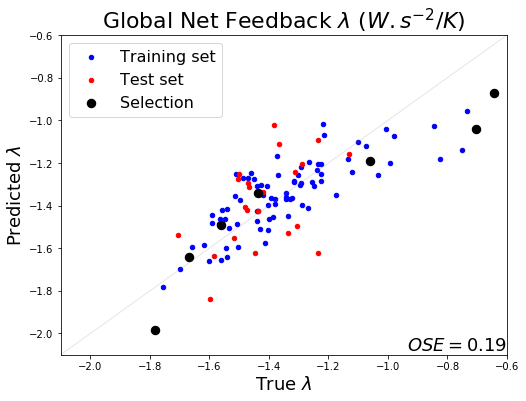

In [70]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title="Global Net Feedback $\lambda$ ($W.s^{-2}/K$)"
Validation_fdbck_df[0:80].plot(kind='scatter', x='Fdbck_PPE', y='Fdbck_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
Validation_fdbck_df[80:].plot(kind='scatter', x='Fdbck_PPE', y='Fdbck_multilinreg_val', color='red',  
                     marker="o", ax = ax)
df_fdbck_selection.plot(kind='scatter', x='fdbck_arpege', y='fdbck_multilinreg', color='black',  
                     marker="o", linewidth=5,ax = ax)

plt.text(1,0,r'$OSE = 0.19$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

plt.xlabel('True $\lambda$', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted $\lambda$', fontsize = 18)#, fontsize=18)
plt.legend(['Training set', 'Test set', 'Selection'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(-2.1,-0.6)
plt.xlim(-2.1,-0.6)
ax.plot((-4.0,0.6), (-4.0,0.6), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/Fdbck_selection_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

# Retour aux paramètres

In [ ]:
param_names = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy')
E_emulator_df = E_multilinreg_df.reset_index()

x_emulator = pd.DataFrame(LHS, columns= param_names)
x_emulator['RMSE_total'] = E_emulator_df['RMSE_total']

x_emulator['RMSE_total_round'] = x_emulator['RMSE_total'].round(decimals=1)
x_emulator['members'] = range(0,100000,1) 

#x_emulator = x_emulator.set_index('RMSE_total_round')
#x_emulator_new_df=pd.DataFrame()
#x_emulator_new_df['RMSE_total_best'] = x_emulator['RMSE_total'].groupby('RMSE_total_round').min()
#x_emulator_new_df = x_emulator_new_df.reset_index()
#x_emulator_new_df

In [ ]:
x_emulator

In [ ]:
x_init1 = pd.DataFrame(x_best, columns=[i+'_init1' for i in param_names])
x_init1['members'] = range(0, len(x_init1), 1)
x_init1 = x_init1.set_index('members')

#x_init1

x_optim1 = pd.DataFrame()
for i in range(0,len(param_names),1) :
    j = i+1
    x_optim1[param_names[i]+'_optim1'] = sol_df['x'+str(j)+'_smth_0']
x_optim1['members'] = range(0, len(x_init1), 1)
x_optim1 = x_optim1.set_index('members')
#x_optim1

x_init2 = pd.DataFrame()
for i in range(0,len(param_names),1) :
    j = i+1
    x_init2[param_names[i]+'_init2'] = new_sol_df['x'+str(j)+'_smth_150']
x_init2['members'] = range(0, len(x_init1), 1)
x_init2 = x_init2.set_index('members')
#x_init2

x_optim2 = pd.DataFrame()
for i in range(0,len(param_names),1) :
    j = i+1
    x_optim2[param_names[i]+'_optim2'] = sol_df_2['x'+str(j)+'_smth_0']
x_optim2['members'] = range(0, len(x_init1), 1)
x_optim2 = x_optim2.set_index('members')
#x_optim2

X = x_init1.merge(x_optim1, on = ['members']).merge(x_init2, on = ['members']).merge(x_optim2, on = ['members'])
X['Fdbck'] = sol_df_2['Fdbck']
X

In [ ]:
sol_df_2['RMSE'] = sol_df_2['sol_fun'].round(decimals=2)
sol_df_2

In [ ]:
def plot_param(df, param_y, xlabel, ylabel, hue, colors, param_names, ax):
    
    sns.scatterplot(data=df, x="Fdbck", y=param_y+'_smth_0', hue=hue, legend = 'full', palette=colors, ax=ax)
    
    plt.plot(p1_feedbacks, p1_params[ylabel], color='black', marker='+', linewidth=0, markersize=50)
    
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    #plt.legend(legend, fontsize=15)
    #plt.title('Param 1 et 2', fontsize=30)
    #ax.legend([None])
    ax.get_legend().remove()
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlim(-2.2,-0.5) 
    ind = df[param_y+'_smth_0'].max() - df[param_y+'_smth_0'].min()
    if p1_params[ylabel]<df[param_y+'_smth_0'].min() :
        lim_min = p1_params[ylabel]
    else :
        lim_min = df[param_y+'_smth_0'].min()
    
    if p1_params[ylabel]>df[param_y+'_smth_0'].max() :
        lim_max = p1_params[ylabel]
    else :
        lim_max = df[param_y+'_smth_0'].max()
        
    plt.ylim(lim_min-ind/10,lim_max+ind/10)

    # Show la figure .................
    #plt.show()

In [ ]:
# READ FROM ROMAIN REF NAMELIST 

p1_params = {}
p1_params['AKN'] = 0.126
p1_params['ALPHAT'] = 1.13
p1_params['ALD'] = 1.18
p1_params['ALMAVE'] = 10.0
p1_params['AGREF'] = -0.36
p1_params['AGRE1'] = 5.5
p1_params['AGRE2'] = 0.0
p1_params['RAUTEFR'] = 0.001
p1_params['RQLCR'] = 0.0002
p1_params['RAUTEFS'] = 0.0052
p1_params['RQICRMIN'] = 0.0000001
p1_params['RQICRMAX'] = 0.000021
p1_params['TFVL'] = 0.02
p1_params['TFVI'] = 0.04
p1_params['TFVR'] = 3.0
p1_params['TFVS'] = 0.6
p1_params['RKDN'] = 0.00005
p1_params['RKDX'] = 0.0001
p1_params['TENTR'] = 0.000004
p1_params['TENTRX'] = 0.00006
p1_params['VVN'] = -2.0
p1_params['VVX'] = -35.0
p1_params['ALFX'] = 0.04
p1_params['FNEBC'] = 10.0
p1_params['GCTURB'] = 0.00005
p1_params['RLWINHF_ICE'] = 0.9
p1_params['RLWINHF_LIQ'] = 0.9
p1_params['RSWINHF_ICE'] = 0.71
p1_params['RSWINHF_LIQ'] = 0.71
p1_params['REFLCAPE'] = 2.0

np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_params', p1_params)
#p1_params

In [ ]:
df=sol_df_2
hue = df['RMSE']
legend = df['RMSE']
xlabel = 'Fdbck'
colors = plt.cm.get_cmap('summer')

plt.subplots(figsize=(25,25)) 
ax={}

for i in range(0, 30, 1) :
    
    plt.subplot(6,5,(i+1))
    ax[str(i)] = plt.gca()
    param_y= 'x'+str(i+1)       
    ylabel = param_names[i]
    plot_param(df, param_y, xlabel, ylabel, hue, colors, param_names, ax[str(i)])
        

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)
plt.legend(fontsize=22, bbox_to_anchor=(1.05, 7.5), loc=2)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/param_fdbck_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()